In [1]:
import pandas as pd
import os
from scipy import stats
import numpy as np
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt

### Preparation: Calculate the forward returns for stocks and market indices

In [2]:
csv_path = "Data/"
stockclose = "StockClosePrice"
indexclose = "IndexClosePrice"

forward_day = 5 # this should depend on the rolling period

# calculate the forward returns
stock = pd.read_csv(stockclose + ".csv", index_col = 0, parse_dates = True)
stockforward = stock.shift(periods = -forward_day, freq = None, axis = 0)
# 5Dforward(t) = (close_price(t+5)-close_price(t))/close_price(t)
stockforwardreturn = (stockforward - stock) / stock
print(stockforwardreturn.head())
stockforwardreturn.to_csv(os.path.join('5DForward.csv')) #stock

index = pd.read_csv(indexclose + ".csv", index_col = 0, parse_dates = True)
indexforward = index.shift(periods = -forward_day, freq = None, axis = 0)
indexforwardreturn = (indexforward - index) / index
print(indexforwardreturn.head())
indexforwardreturn.to_csv(os.path.join('mkt_5DForward.csv')) #mkt

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2007-01-04   0.047482   0.061368   0.088638   0.186231   0.065688   0.122858   
2007-01-05   0.188363   0.084177   0.094316   0.107551  -0.016348   0.037043   
2007-01-08   0.219149   0.158273   0.103618   0.111985   0.006898   0.031495   
2007-01-09   0.233333   0.230769   0.096691   0.135329   0.075422   0.031128   
2007-01-10   0.208806   0.006994   0.083142   0.096759  -0.043272   0.007674   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2007-01-04   0.250000   0.125307        0.0   0.128390  ...        NaN   
2007-01-05   0.122891   0.073622        0.0   0.079454  ...        NaN   
2007-01-08   0.140277   0.086213        0.0   0.092567  ...        NaN   
2007-01-09   0.130120   0.044423        0.0   0.123708  ...        Na

In [2]:
stockforwardreturn = pd.read_csv('5DForward.csv', index_col = 0, parse_dates = True)

In [3]:
stockforwardreturn.shape

(2824, 3584)

## Read the factors

In [4]:
factor_folder = "ALL_factors/"
factor_list = set(os.listdir(factor_folder)) - set(['.DS_Store'])
factor_list = list(factor_list)

# Read all factor files
# Z-score the factor values to remove the scale differences
dfs = []
i = 0
for factor in factor_list:
    dfs.append(factor)
    df = pd.read_csv(factor_folder + factor , index_col = 0, parse_dates = True)
    dfs[i] = (df - df.mean()) / df.std() 
    i = i + 1

print(dfs[0].head())

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2008-01-02        NaN        NaN        NaN        NaN        NaN        NaN   
2008-01-03        NaN        NaN        NaN        NaN        NaN        NaN   
2008-01-04        NaN        NaN        NaN        NaN        NaN        NaN   
2008-01-07        NaN        NaN        NaN        NaN        NaN        NaN   
2008-01-08        NaN        NaN        NaN        NaN        NaN        NaN   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2008-01-02        NaN        NaN        NaN        NaN  ...        NaN   
2008-01-03        NaN        NaN        NaN        NaN  ...        NaN   
2008-01-04        NaN        NaN        NaN        NaN  ...        NaN   
2008-01-07        NaN        NaN        NaN        NaN  ...        Na

## Data merge

In [5]:
# clean return data
import datetime
# rows cleaning
st = datetime.datetime(2008, 1, 2, 0, 0)
en = datetime.datetime(2018, 7, 5, 0, 0)
rt =stockforwardreturn[st:en]

In [6]:
# Delete the stocks that do not exist in factors files
a = dfs[0].columns.tolist()
b = rt.columns.tolist()
more = list(set(b) - set(a))
rt = rt.drop(more,axis=1)

In [7]:
# Change the return to 2 dimension
rt = rt.reset_index()
value_vars = rt.columns.tolist()[1:]
rt = pd.melt(frame=rt ,id_vars='date', value_vars=value_vars, var_name='stock',value_name='return')

# Change each factor table to 2 dimension
for i in range(len(dfs)):
    dfs[i] = dfs[i].reset_index()
    value_vars = dfs[i].columns.tolist()[1:]
    value_name = factor_list[i].rstrip('.csv')
    dfs[i] = pd.melt(frame=dfs[i],id_vars='date',value_vars=value_vars,var_name='stock',value_name=value_name)

In [8]:
# Merge 44 factor tables
melted = pd.DataFrame()
melted = pd.concat([melted,dfs[0]],axis=1)
for i in range(1,len(dfs)):
    melted = pd.merge(left=melted,right=dfs[i],on=['date','stock'])

In [9]:
melted.shape

(9125933, 46)

In [10]:
# Merge the return with the factors
melted = pd.merge(left=melted,right=rt,on=['date','stock'])

print(melted.head())
print(melted.shape)

        date      stock  RealizedVolatility    TVMA20       SUE     DAREV  \
0 2008-01-02  000001.SZ                 NaN -0.073158  6.085141  0.454935   
1 2008-01-03  000001.SZ                 NaN -0.089092  6.085141 -0.619202   
2 2008-01-04  000001.SZ                 NaN -0.097660  6.085141 -0.972252   
3 2008-01-07  000001.SZ                 NaN -0.061294  6.085141 -1.072171   
4 2008-01-08  000001.SZ                 NaN  0.034590  6.085141 -1.038865   

   PEHist120        AD  LongTermDebtToAsset   PCFIndu  ...     TVMA6  \
0  -0.056532 -0.992037                  NaN -0.286648  ... -0.001905   
1  -0.087318 -0.991141                  NaN -0.290260  ...  0.022230   
2  -0.039740 -0.986487                  NaN -0.294426  ...  0.032540   
3  -0.002984 -0.981773                  NaN -0.300815  ...  0.149184   
4   0.053177 -0.981442                  NaN -0.300815  ...  0.268527   

   GainVariance20  GainLossVarianceRatio20      ROE5  MoneyFlow20  \
0        0.874219                 0

In [11]:
# Drop na values
na = melted.dropna()
na.shape

(1850785, 47)

## Train Test Split

In [12]:
# Change X and y to pure data
# Delete the information labels
X=na.drop(['return','date','stock'],axis=1)
y=na.filter(['return'])

In [13]:
# Normalize the return
y_n = (y - y.mean()) / y.std()

In [14]:
# Split the data to train and test sets with test size 0.25
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y_n,test_size=0.25,random_state=233)
print(X_train.head())
print(y_train.head())

         RealizedVolatility    TVMA20       SUE     DAREV  PEHist120  \
1505660           -0.748071 -0.152824 -1.935921  0.063639  -0.043659   
1171801           -0.015382  0.387712 -0.007923 -1.183333   0.028114   
1115312           -0.045630  0.820369 -0.249730  1.820080   0.046810   
1062637            0.676585 -0.101303  0.505055  0.001838  -0.020444   
1354344           -0.758018  2.184009 -0.427864 -0.126468   2.018766   

               AD  LongTermDebtToAsset   PCFIndu  MktValue  \
1505660 -1.178199            -0.490560 -0.018841  0.542207   
1171801 -0.554253            -0.411818  3.066563  1.695701   
1115312  0.375281            -0.004054  2.771882  0.852176   
1062637 -0.298271             0.350603 -0.179703  0.973626   
1354344  0.791503            -0.341514 -0.437504  1.131109   

         InformationRatio60  ...   Price1Y     TVMA6  GainVariance20  \
1505660            0.778278  ...  0.537736 -0.065422        0.490233   
1171801            0.082754  ...  1.493468  1.1524

## Fit Ridge Model

In [15]:
# Try the build-in cross validation function of Ridge
from sklearn.linear_model import RidgeCV, Ridge

model = RidgeCV(alphas = [0.02, 1.0, 10.0])
model.fit(X_train, y_train)
alpha = model.alpha_

print(alpha)
# print the best alpha selected automatically

10.0


In [16]:
# test the MSE score of models using different alpha on test data set
from sklearn.metrics import mean_squared_error

def run_model(alpha, X_train, y_train, X_test, y_test):
    model = Ridge(alpha = alpha)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse_score = mean_squared_error(y_test, pred)
    return model, mse_score

model1, mse1 = run_model(0.1, X_train, y_train, X_test, y_test)
model2, mse2 = run_model(1.0, X_train, y_train, X_test, y_test)
model3, mse3 = run_model(10.0, X_train, y_train, X_test, y_test)

print('MSE1:', mse1)
print('MSE2:', mse2)
print('MSE3:', mse3)

MSE1: 0.9828713212778244
MSE2: 0.9828713184650292
MSE3: 0.9828712903854071


In [17]:
# Choose the best alpha, which is 10
ridge_predictor = model3.predict(X)
ridge_result=pd.DataFrame(ridge_predictor)

## Write to csv

In [18]:
# Prepare the original data frame and the result data frame to merge together
melted_reduce = melted[['date', 'stock']]
print(melted_reduce.head())
na.insert(loc=0,column='predictedy',value=ridge_result.values)
na_reduce = na[['date', 'stock', 'predictedy']]
print(na_reduce.head())

        date      stock
0 2008-01-02  000001.SZ
1 2008-01-03  000001.SZ
2 2008-01-04  000001.SZ
3 2008-01-07  000001.SZ
4 2008-01-08  000001.SZ
           date      stock  predictedy
2877 2009-04-27  000002.SZ    0.075356
2878 2009-04-28  000002.SZ    0.084639
2879 2009-04-29  000002.SZ    0.084032
2880 2009-04-30  000002.SZ    0.092599
2881 2009-05-04  000002.SZ    0.116629


In [19]:
# Merge the two data frame together
for_bt=pd.merge(melted_reduce,na_reduce,how='left',on=['date','stock'])

In [20]:
# Change to the format that can be put in Backtest
# Write to csv
td_bt=pd.Series(list(for_bt['predictedy']),index=[for_bt['date'],for_bt['stock']])
td_bt=td_bt.unstack()
print(td_bt.shape)
save_result_path = 'Ridge_factors'
td_bt.to_csv(os.path.join(save_result_path, 'Ridge.csv'))

(2557, 3569)


## Backtesting Simulation

After you save the score from your new factor in the same format as "Simple_Mean_factor.csv". You can directly run the following codes to see the backtesting simulation results. 

"helper.py" contains all formulas and plotting functions.

"backtestlite.py" contains the whole simulation process. 



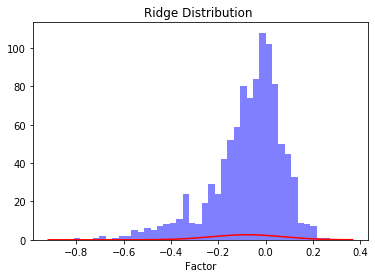

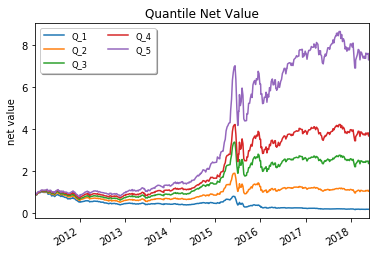

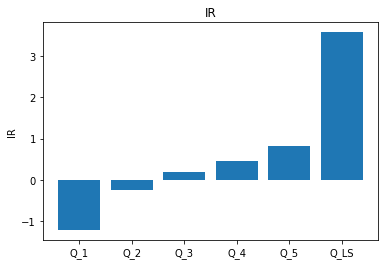

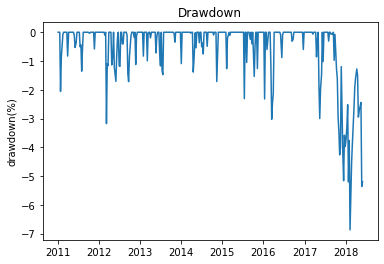

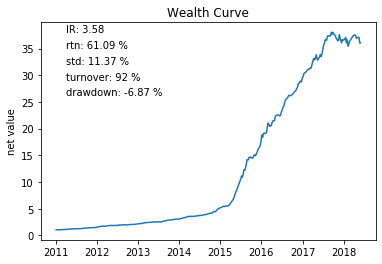

In [22]:
import backtestlite as bt
import helper

working_directory = 'Data/'
#Directory to import the factor you built
factor_path_all = 'Ridge_factors'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join("5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join("mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor = "Ridge"

Type = "LS" # this stand for long-short strategy. 

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = bt.Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = helper.DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)